# Intro a Qiskit

In [4]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister

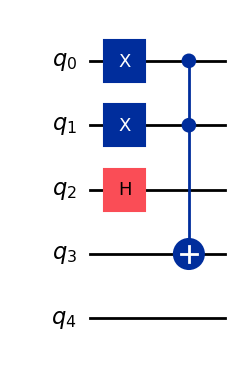

In [15]:
qc = QuantumCircuit(5)
qc.x(range(2))
qc.ccx(0, 1, target_qubit= 3)
qc.h(2)
qc.draw('mpl')



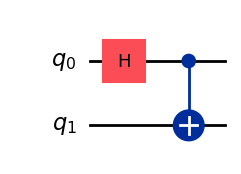

In [19]:
from qiskit.quantum_info import Statevector, DensityMatrix

qc = QuantumCircuit(2)

qc.h(0)
qc.cx(0, 1)

qc.draw('mpl')

In [20]:
DensityMatrix(qc).draw('latex')

<IPython.core.display.Latex object>

In [44]:
from qiskit_nature.second_q.drivers import PySCFDriver

driver = PySCFDriver(atom= 'H 0 0 0 ; H 0 0 0.7')

problema = driver.run()


fermionic_op = problema.hamiltonian.second_q_op()

$$\hat{H} = \sum_{ij} h_{ij} a^{\dagger}_i a_j + \cdots$$

In [45]:
from qiskit_nature.second_q.mappers import  JordanWignerMapper


mapper = JordanWignerMapper()

sparse_pauli_ham = mapper.map(fermionic_op)

sparse_pauli_ham


SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IZII', 'ZIII', 'IIZZ', 'IZIZ', 'ZIIZ', 'YYYY', 'XXYY', 'YYXX', 'XXXX', 'IZZI', 'ZIZI', 'ZZII'],
              coeffs=[-0.79804642+0.j,  0.17771287+0.j, -0.24274281+0.j,  0.17771287+0.j,
 -0.24274281+0.j,  0.12293305+0.j,  0.17059738+0.j,  0.16768319+0.j,
  0.04475014+0.j,  0.04475014+0.j,  0.04475014+0.j,  0.04475014+0.j,
  0.16768319+0.j,  0.17627641+0.j,  0.12293305+0.j])

In [50]:
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock

init_state = HartreeFock(num_spatial_orbitals= problema.num_spatial_orbitals,
            num_particles= problema.num_particles,
            qubit_mapper= mapper)

#init_state.draw('mpl')


ansatz = UCCSD(
    2,
    problema.num_particles,
    mapper,
    initial_state=HartreeFock(
        problema.num_spatial_orbitals,
        problema.num_particles,
        mapper,
    ),
)

#ansatz.decompose(reps=4).draw('mpl')

In [55]:
import numpy as np
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import SLSQP
from qiskit.primitives import Estimator



vqe = VQE(Estimator(), ansatz, SLSQP())

from qiskit_nature.second_q.algorithms.initial_points import HFInitialPoint


initial_point = HFInitialPoint()
initial_point.ansatz = ansatz
initial_point.problem = problema
vqe.initial_point = initial_point.to_numpy_array()


In [60]:
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
solver = GroundStateEigensolver(mapper, vqe)
result = solver.solve(problema)

print(f"Total ground state energy = {result.total_energies[0]:.4f}")

Total ground state energy = -1.1362


In [74]:
distances = np.arange(0.5, 1, 0.01)

energies = np.zeros(len(distances))

#from qiskit_aer import AerSimulator
#from qiskit_aer.primitives import Estimator as AerEstimator

for i, d in enumerate(distances):
    #iniciamos el problema
    driver = PySCFDriver(atom= f'H 0 0 0 ; H 0 0 {d}')
    problema = driver.run()
    fermionic_op = problema.hamiltonian.second_q_op()
    
    #mapeamos
    mapper = JordanWignerMapper()

    sparse_pauli_ham = mapper.map(fermionic_op)

    init_state = HartreeFock(num_spatial_orbitals= problema.num_spatial_orbitals,
            num_particles= problema.num_particles,
            qubit_mapper= mapper)

#init_state.draw('mpl')


    ansatz = UCCSD(
        2,
        problema.num_particles,
        mapper,
        initial_state=HartreeFock(
            problema.num_spatial_orbitals,
            problema.num_particles,
            mapper,
        ),
    )


    vqe = VQE(Estimator(), ansatz, SLSQP())


    initial_point = HFInitialPoint()
    initial_point.ansatz = ansatz
    initial_point.problem = problema
    vqe.initial_point = initial_point.to_numpy_array()

    solver = GroundStateEigensolver(mapper, vqe)
    result = solver.solve(problema)

    energies[i] = result.total_energies[0]
    #

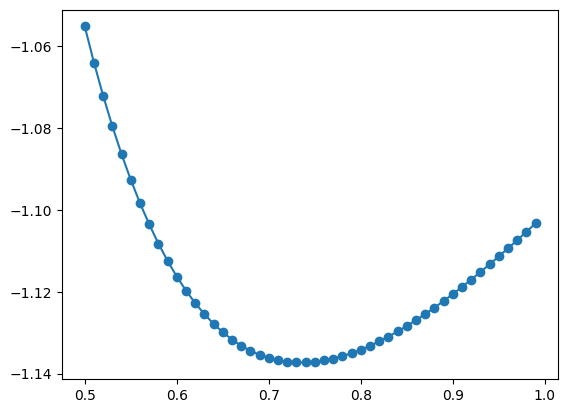

In [75]:
import matplotlib.pyplot as plt

plt.scatter(distances[:], energies[:])
plt.plot(distances[:], energies[:])

